In [1]:
import pandas as pd #导入Pandas
import numpy as np #导入Numpy
import jieba #导入结巴分词
import jieba.analyse
 
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU

print("————————语料预处理：数据导入————————")
reviewfile=pd.read_csv('review30000.csv') #读取训练语料完毕
reviewfile

Using TensorFlow backend.


————————语料预处理：数据导入————————


E:\anada\envs\tensorflow\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,c.city_name,a.shopid,口味评分,环境评分,服务评分,b.reviewbody,Unnamed: 7,Unnamed: 8
0,1.0,上海,500001.0,3.0,4.0,4.0,这种地方，环境好是肯定的～吃的羊排什么的。还行吧～,NaN,NaN
1,2.0,上海,500003.0,0.0,1.0,1.0,这是一家在中国的中餐馆，口味、菜单、摆盘（菜量）和任何一家四星本帮菜都没法比… …,NaN,NaN
2,3.0,上海,500019.0,3.0,4.0,4.0,天天中午发愁吃什么，刚好走进中信泰富，为了不过多纠结就和小伙伴决定吃意面。意面分量足够，吃完...,NaN,NaN
3,4.0,上海,500028.0,2.0,0.0,0.0,很多年前在电视上见过介绍这家饭店，就在网上搜索过评论不怎么样也就作罢了，此次有亲戚介绍推荐上...,NaN,NaN
4,5.0,上海,500057.0,4.0,4.0,4.0,去了好几次，德国猪肘是这里的特色菜，基本上每桌必点！还有这里的生啤也不错！如果要坐外面需要自...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1048570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
reviewdata = pd.DataFrame()
reviewdata["reviewbody"]= reviewfile["b.reviewbody"]
reviewdata["score1"]= reviewfile["口味评分"]
reviewdata["score2"]= reviewfile["环境评分"]
reviewdata["score3"]= reviewfile["服务评分"]
reviewdata = reviewdata.dropna(axis=0,how='any') #去掉所有有缺失值的行
print("reviewdata的数据格式为：")
print(reviewdata.info())
print("【over】")

reviewdata的数据格式为：
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewbody  30000 non-null  object 
 1   score1      30000 non-null  float64
 2   score2      30000 non-null  float64
 3   score3      30000 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.1+ MB
None
【over】


In [3]:
reviewdata

,reviewbody,score1,score2,score3
0,这种地方，环境好是肯定的～吃的羊排什么的。还行吧～,3.0,4.0,4.0
1,这是一家在中国的中餐馆，口味、菜单、摆盘（菜量）和任何一家四星本帮菜都没法比… …,0.0,1.0,1.0
2,天天中午发愁吃什么，刚好走进中信泰富，为了不过多纠结就和小伙伴决定吃意面。意面分量足够，吃完...,3.0,4.0,4.0
3,很多年前在电视上见过介绍这家饭店，就在网上搜索过评论不怎么样也就作罢了，此次有亲戚介绍推荐上...,2.0,0.0,0.0
4,去了好几次，德国猪肘是这里的特色菜，基本上每桌必点！还有这里的生啤也不错！如果要坐外面需要自...,4.0,4.0,4.0
...,...,...,...,...
29995,期待的快餐，菜品丰富，份量足！,4.0,4.0,4.0
29996,强烈推荐崇明中兴镇高大上休闲场所。带上你们的亲朋好友一起来happy！来了会有意外惊喜哟！,4.0,4.0,4.0
29997,水果船味道不错，甜甜的，比较好吃。军舰拼盘实惠，口味多，都市我喜欢的。店内招牌更好说一下了风...,4.0,4.0,4.0
29998,长风景畔广场自从变身为长风大悦城之后，格局大改造，好久没来大变样了，一楼的好多商铺都移至地下...,2.0,1.0,1.0


In [4]:
#【函数】查看pandas数据的信息
def getinfo(inputdata):
    print("文件的具体信息如下==========")
    info = inputdata.info()
    print(info)
    print("===========")

#【函数】分词&清洗无用词
def cutwords(review_data):
    cw = lambda x: list(jieba.cut(x)) 
    review_data['words'] = review_data["reviewbody"].apply(cw)
    print("——————————分词结束——————————")
    
    delwordslist = "，/,/。/的/！/～/、/（/）/ /./。/吧".split("/")
    for i in review_data.index:
        one = review_data.words[i]
        for k in one:
            if k in delwordslist:
                one.remove(k)
        i +=1
    print("——————————清洗无用词结束——————————")
    return review_data

#【函数】构建词频字典（输入的数据需要经过cutwords（））
def dict_words(review_data):
    w = []
    for i in review_data["words"]:
        w.extend(i)
        #########统计词出现的次数,生成次的映射字典
    word_dict = pd.DataFrame(pd.Series(w).value_counts(),columns = ["counts"])
    word_dict.to_csv("word_dict(词组映射).csv",index=True,header=True)
    word_dict['id'] = list(range(1, len(word_dict)+1))
    getinfo(word_dict)
    word_dict.to_csv("word_dict(词组映射).csv",index=True,header=True)
    print("词典构建完成，输出文件word_dict(词组映射).csv——————【over】")
    return word_dict


#【函数】词向量化
def arraywords(review_data,word_dict):
    maxlen = 50
    review_data['sent'] = review_data['words'].apply(lambda x: list(word_dict['id'][x]))
    #review_data['sent'] = list(sequence.pad_sequences(review_data['sent'], maxlen=maxlen))
    review_data['sent'] = list(sequence.pad_sequences(review_data['sent'], maxlen=maxlen))
    print("——————————词向量化结束——————————")
    return review_data

#【函数】给数据打标:
def markwords(inputdata):
    inputdata["totalscore"] = inputdata.score1+inputdata.score2+inputdata.score3 
    inputdata["pos_or_neg"] = pd.Series()
    pos = inputdata[inputdata.totalscore>11]
    pos["pos_or_neg"]=1
    neg = inputdata[inputdata.totalscore<7]
    neg["pos_or_neg"] = 0
    inputdata = pos.append(neg)
    print("——————————标注结束——————————")
    print("得到{}条正向评论，{}条负向评论".format(len(pos),len(neg)))
    return inputdata

#【函数】训练过程可视化图表
import keras
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline



In [5]:
a=pd.read_csv('word_dict(词组映射).csv')
a

,Unnamed: 0,counts,id
0,了,33012,1
1,很,23091,2
2,吃,17847,3
3,是,16398,4
4,也,16130,5
...,...,...,...
46966,养肝,1,46967
46967,15.3,1,46968
46968,最忙,1,46969
46969,水笔,1,46970


In [6]:
a = cutwords(reviewdata)
word_dict = dict_words(a)

Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\pc\AppData\Local\Temp\jieba.cache
Loading model cost 1.059 seconds.
Prefix dict has been built successfully.


——————————分词结束——————————
——————————清洗无用词结束——————————
文件的具体信息如下==========
<class 'pandas.core.frame.DataFrame'>
Index: 46971 entries, 了 to 借用
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   counts  46971 non-null  int64
 1   id      46971 non-null  int64
dtypes: int64(2)
memory usage: 1.1+ MB
None
词典构建完成，输出文件word_dict(词组映射).csv——————【over】


In [7]:
#开始调用函数处理数据：

reviewdata_sented = arraywords(a,word_dict)
print("完成（词向量化），得到 reviewdata_sented ：")
print(reviewdata_sented.info())
reviewdata_marked = markwords(reviewdata_sented)
reviewdata_marked.to_csv("reviewdata_marked(词组映射).csv",index=True,header=True)
print("完成（数据情感极性标注），输出文件reviewdata_markeded(词组映射).csv——————【over】")

——————————词向量化结束——————————
完成（词向量化），得到 reviewdata_sented ：
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 0 to 29999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewbody  30000 non-null  object 
 1   score1      30000 non-null  float64
 2   score2      30000 non-null  float64
 3   score3      30000 non-null  float64
 4   words       30000 non-null  object 
 5   sent        30000 non-null  object 
dtypes: float64(3), object(3)
memory usage: 2.9+ MB
None
——————————标注结束——————————
得到13912条正向评论，3798条负向评论


E:\anada\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:51: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
E:\anada\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
E:\anada\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


完成（数据情感极性标注），输出文件reviewdata_markeded(词组映射).csv——————【over】


In [8]:
aa=pd.read_csv('reviewdata_marked(词组映射).csv')
aa

,Unnamed: 0,reviewbody,score1,score2,score3,words,sent,totalscore,pos_or_neg
0,4,去了好几次，德国猪肘是这里的特色菜，基本上每桌必点！还有这里的生啤也不错！如果要坐外面需要自...,4.0,4.0,4.0,"['去', '了', '好', '几次', '德国', '猪肘', '是', '这里', '...",[ 20 1 7 346 2972 6848 4 ...,12.0,1
1,6,以前去过几次衡山路那家 新天地这家是第一次来 新装修过的果然环境很不错 有种置身国外的感觉 ...,4.0,4.0,4.0,"['以前', '去过', '几次', '衡山路', '那', '家', '新天地', '这家...",[ 534 36 25 222 30 2972 1138 1...,12.0,1
2,8,老饭店，味道一如既往好，价格实惠。,4.0,4.0,4.0,"['老', '饭店', '味道', '一如既往', '好', '价格', '实惠']",[ 0 0 0 0 0 0 0 0 0 0 0 ...,12.0,1
3,18,五星好评，避风塘(日月光广场店)必须点个赞，强烈推荐！日月光都快成了我和男票根据地了。第一次...,4.0,4.0,4.0,"['五星', '好评', '避风塘', '(', '日', '月光', '广场', '店',...",[ 57 601 203 8 245 11 118 4053 835 ...,12.0,1
4,19,一般吧，我是外地人，上海服务大魔都，就那样吧，我只能呵呵了,4.0,4.0,4.0,"['一般', '我', '是', '外地人', '上海', '服务', '大魔', '都',...",[ 0 0 0 0 0 0 0 ...,12.0,1
...,...,...,...,...,...,...,...,...,...
17705,29915,很空的一家店却让我等了很久很久；我说要堂吃后，服务员端盘出来，就一个吐司包着纸，要我抱着啃，...,0.0,0.0,0.0,"['很空', '一家', '店', '却', '让', '我', '等', '了', '很久...",[ 236 33 25048 226 13 46 2083 47...,0.0,0
17706,29928,店铺在秋阳路近三门路，三门路菜场入口处。烧饼都是现做的，所以现场等待时间会比较长，尤其前面有...,2.0,2.0,2.0,"['店铺', '在', '秋', '阳路', '近', '三', '门路', '三', '门...",[ 35 22 1 5474 5266 469 454 13 1546 ...,6.0,0
17707,29938,真的很难吃。馍像馒头，肉没有腊汁肉的香。还没自己做的好吃,1.0,2.0,3.0,"['真的', '很', '难吃', '馍', '像', '馒头', '肉', '没有', '...",[ 0 0 0 0 0 0 0 ...,6.0,0
17708,29969,工作日午餐，价格不贵。觉得虾堡还可以啦啦,2.0,3.0,1.0,"['工作日', '午餐', '价格', '不', '贵', '觉得', '虾堡', '还',...",[ 0 0 0 0 0 0 0 ...,6.0,0


In [9]:
#进行神经网络模型搭建
from sklearn import model_selection
from keras.utils import np_utils

seed = 7
X = np.array(list(reviewdata_marked['sent']))
Y = np.array(list(reviewdata_marked['pos_or_neg']))
x_train, x_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.25, random_state=seed)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

model = Sequential()
model.add(Embedding(len(word_dict)+1, 256))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(y_train.shape[1]))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("构建的模型信息为：")
model.summary()
model.get_config()

print("下面开始训练")


# history = LossHistory()
his=model.fit(x_train, y_train, batch_size=32, epochs=10,validation_data=(x_test, y_test))#128时，每个epoch训练92s
# history.loss_plot('epoch')
print("【over】")

构建的模型信息为：
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 256)         12024832  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
_________________________________________________________________
activation_1 (Activation)    (None, 2)                 0         
Total params: 12,550,658
Trainable params: 12,550,658
Non-trainable params: 0
_________________________________________________________________
下面开始训练


E:\anada\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13282 samples, validate on 4428 samples
Epoch 1/10
13282/13282 [==============================] - 283s 21ms/step - loss: 0.3013 - accuracy: 0.8792 - val_loss: 0.2643 - val_accuracy: 0.8943
Epoch 2/10
13282/13282 [==============================] - 285s 21ms/step - loss: 0.1592 - accuracy: 0.9454 - val_loss: 0.2920 - val_accuracy: 0.8828
Epoch 3/10
13282/13282 [==============================] - 255s 19ms/step - loss: 0.0896 - accuracy: 0.9712 - val_loss: 0.4440 - val_accuracy: 0.8747
Epoch 4/10
13282/13282 [==============================] - 242s 18ms/step - loss: 0.0786 - accuracy: 0.9770 - val_loss: 0.4259 - val_accuracy: 0.8812
Epoch 5/10
13282/13282 [==============================] - 242s 18ms/step - loss: 0.0461 - accuracy: 0.9863 - val_loss: 0.4939 - val_accuracy: 0.8708
Epoch 6/10
13282/13282 [==============================] - 252s 19ms/step - loss: 0.0331 - accuracy: 0.9909 - val_loss: 0.5238 - val_accuracy: 0.8776
Epoch 7/10
13282/13282 [==============================] -

In [11]:
import matplotlib.pyplot as plt

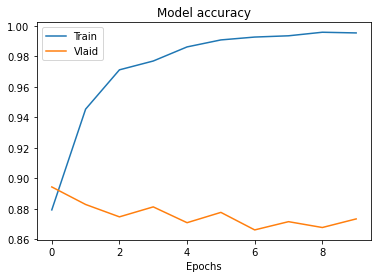

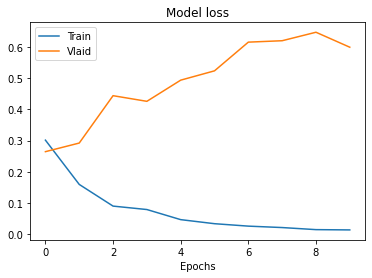

In [12]:
plt.plot(his.history['accuracy'])
plt.plot(his.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Vlaid'],loc='upper left')
plt.show()
plt.plot(his.history['loss'])
plt.plot(his.history['val_loss'])
plt.title('Model loss')
plt.xlabel('loss')
plt.xlabel('Epochs')
plt.legend(['Train','Vlaid'],loc='upper left')
plt.show()

In [13]:
score = model.evaluate(x_test, y_test, verbose=1) 
#【evaluate函数返回什么？？？】
#Scalar test loss (if the model has no metrics)or list of scalars (if the model computes other metrics).
#The attribute `model.metrics_names` will give you
#the display labels for the scalar outputs.
# print ("Test accuracy = :",score)
print('Accuracy:%.2f%%'%(score[1]*100))

4428/4428 [==============================] - 16s 4ms/step
Accuracy:87.33%


In [16]:
def predict_new(reviewdata):
    reviewdata_sent = arraywords(reviewdata,word_dict)
    x = np.array(list(reviewdata_sent['sent']))
    y = model.predict_classes(x)
    y_score = model.predict(x)
    y_out = y.tolist()
    y_score_out = y_score.tolist()
    predict_result = pd.DataFrame()
    predict_result["reviewinput"] = pd.Series(reviewdata.reviewbody)
    predict_result["p:pos_or_neg"] = y_out
    predict_result["p:score"] = y_score_out
    return predict_result

#输入一个评论来预测
def predict_one(review):
    words = re.findall('[\x80-\xff]{3}|[\w\W]', review)
    print("words = ",words)
    sent = []
    for x in words:
        get_id = list(word_dict["id"][word_dict.index == x].values)
        sent.extend(get_id)
    print("sent = ",sent)
    x_input = sequence.pad_sequences([sent], maxlen=25)
    print("x_input = ",x_input)
    predicted = model.predict_classes(x_input, verbose=0)
    return predicted

def new_data_predict(new_comment):
    words = list(jieba.cut(new_comment))
    sent = [word_dict['id'][x] for x in words]
    xn = sequence.pad_sequences([sent], maxlen=50)
    yn = model.predict_classes(xn,verbose = 0)
    y_score = model.predict(xn,verbose = 0)
    print("预测结果：",yn)

In [17]:
a = "我就呵呵了,菜都烧烂了"
new_data_predict(a)

预测结果： [0]


In [18]:
a = "呵呵，难吃的要死，他们竟然说好吃"
new_data_predict(a)

预测结果： [0]


In [19]:

import jieba
list0 = jieba.cut('小银今天脱单了没')
print('分词后:'+' '.join(list0))

分词后:小银 今天 脱单 了 没


In [20]:
a = "我就呵呵了，前面的评论是怎么得出这里好吃的结论的？这菜也太难吃了吧，下次再也不来了"
new_data_predict(a)

预测结果： [0]


In [21]:
a='可真好吃，下次还来'
new_data_predict(a)

预测结果： [1]
